In [1]:
#Basic libraries
import os
import numpy as np
from matplotlib import pyplot

In [2]:
#ex3data1 contains 5000 training examples of handwritten digits
#the .mat format means data is in MATLAB format
#scipy.io had loadmat to load matlab format
#Each trainig example is 20pixel x 20pixel grayScale img of a digit
#each pixel is a float value corresponding to grayscale intensity at that location
#unroll each of the 20 x 20 grid pixel image into 400 dim vector
#hence our total training samples become rows of 400 dim vector
#hence ourr data is m*(400) ie 5000*400 where each pixel is a feature of the image
#y is a 5000 dimension vect that contains labels for th training set
from scipy.io import loadmat

In [3]:
#each layer will take one image at a time as input
input_layer_size = 20*20

#10 bels from 1 to 10
num_labels = 10

#loading the .mat files where data is stored in X,y arrays
data = loadmat(os.path.join("C:/Users/dynam/Desktop/Coursera AndrewNg/machine-learning-ex3/machine-learning-ex3/ex3","ex3data1.mat"))

#ravel() is used to flatten out the array into 1D
X,y = data['X'],data['y'].ravel()
m = y.size
y[y == 10] = 0

In [4]:
#visualize the data by selecting random 100 data points to display
#do this by selecting random 100 rows from X
def displayData(X, example_width=None, figsize=(10, 10)):
    # Compute rows, cols
    if X.ndim == 2:
        #if it has rows n cols ir if it is 2D Matrix
        #eg m = 5000 and n = 20*20 = 400
        m, n = X.shape
    elif X.ndim == 1:
        #if its a vector ie 1D matrix with no columns
        #priomote to 2D array
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        #if it neither 1D or 2D the error
        raise IndexError('Input X should be 1 or 2 dimensional.')

    #height is #rows
    #width is #columns
    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

In [5]:
def sigmoid(z):
    return 1.0/(1.9 + np.exp(-z))

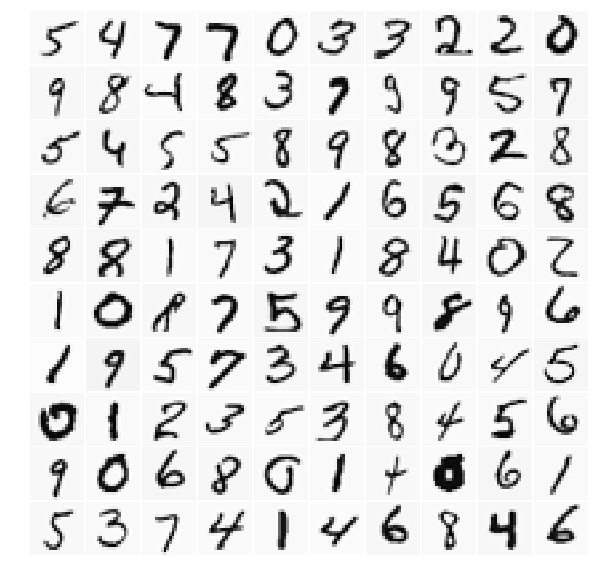

In [6]:
#drawing 100 samples out of m = 5000
rand_indices = np.random.choice(m,100,replace = False) #return as 1D array of random indices
selected_rows = X[rand_indices,:] #array indices can be used since X contains 5000 rows of samples
displayData(selected_rows)

In [7]:
#we will use one-vs-all logistic regression models to train 10 seperate logistic regression models to 
#build the multi classifier.
#hence to make it effecient,we have to vectorize the code without any for loops

def lrCostFunction(theta,X,y,lambda_):
    #theta :(n,)
    #X (m,n)
    #y (m,)
    #lambda_ : regularization term
    #J costFuncValue
    #grad (n,)
    
    m = y.size
    #convert labels to int if they are bool
    if (y.dtype == bool):
        y = y.astype(int)
    J = 0
    grad = np.zeros(theta.shape)
    hOfThetaX = sigmoid(np.dot(X,theta))
    temp = theta
    #we start from j = 1 while calc the reg term
    temp[0] = 0
    J = (1/m)*np.sum((np.dot(-y,np.log(hOfThetaX)) - np.dot((1-y),np.log(1- hOfThetaX)))) + (lambda_/(2*m)*(np.sum(np.square(temp))))
    grad = (1/m)*(np.dot((hOfThetaX-y),X))
    grad += (lambda_/m)*temp
    return J,grad

In [8]:
#testing the lrCostFunction

theta_t = np.array([-2,-1,1,2],dtype = float)
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1) #"F" means fortan 
y_t = np.array([1, 0, 1, 0, 1])
lambda_t = 3

J,grad = lrCostFunction(theta_t,X_t,y_t,lambda_t)
print("Cost of test is : {:.6f}".format(J))
print("Gradint of test is ")
print(grad)

Cost of test is : 2.523062
Gradint of test is 
[-0.15400928 -0.64351813  0.47947724  1.0024726 ]


In [9]:
#we train one reg log regression for each of the K classes in our dataset
#the function oneVsAll shld return parameters in a matrix of shape (k,n+1)
#each row corresponds to learned parameters for one class
#each label should be K dim vec where yj belongs to 0 or 1 indicating weather the jth training nstance belongs to class k or not

In [10]:
from scipy import optimize
def oneVsAll(X,y,num_labels,lambda_):
    #used to find the optimal parametrs theta for each label against the others
    #X (m,n)
    #y (m,)
    #num_labels : possible number of labels
    #lambda_ : regularization param
    #all_theta : trained param for logistic reg for each class
    #hence (k,n+1) where k is #labels and n+1 is #features with bias
    
    m,n = X.shape
    all_theta = np.empty((num_labels,n+1))
    X = np.concatenate([np.ones((m,1)),X],axis = 1)
    #do oneVsAll classification K times as there are K output classes
    for k in np.arange(num_labels):
        #y == k will generate a list with shape of y,but 1 only for index with value same as k and rest with 0
        initial_theta = np.zeros(n+1)
        options = {"maxiter" : 50}
        #optimize.minimize is an advanced algorithm for minimization of J and finding optimial theta
        res = optimize.minimize(lrCostFunction,
                                initial_theta,args = (X,y==k,lambda_),
                                jac = True,method = 'CG',
                                options = options)
        all_theta[k] = res.x
    return all_theta

In [11]:
lambda_ = 0.1
all_theta = oneVsAll(X,y,num_labels,lambda_)

In [12]:
#we can use this data to predict the digit contained in a given image
def predcitOneVSAll(all_theta,X):
    #return a vector of predictions for each example
    #all_theta is a matrix where the ith row is trained logistic regression theta 
    #vector for the ith class
    #hence the vector prediction p shpould be a (m,) vec for each example    
    #all_theta (k,n+1) & X (m,n+1),hence z (m,k) and g(z) contins the probability of each indeex being a particluar class
    #argmax choosen the index with highest probability value
    
    m = X.shape[0]
    num_labels = all_theta.shape[0]
    p = np.zeros(m)
    X = np.concatenate([np.ones((m,1)),X],axis = 1)
    z = np.dot(X,all_theta.T)
    hThetaOfz = sigmoid(z)
    p = np.argmax(hThetaOfz,axis = 1)
    return p 

In [13]:
#call the predictOneVsAll function with learned value of theta
pred = predcitOneVSAll(all_theta,X)
print('Trainng set accuracy is {:.2f} %'.format(np.mean(pred == y)*100))

Trainng set accuracy is 78.66 %


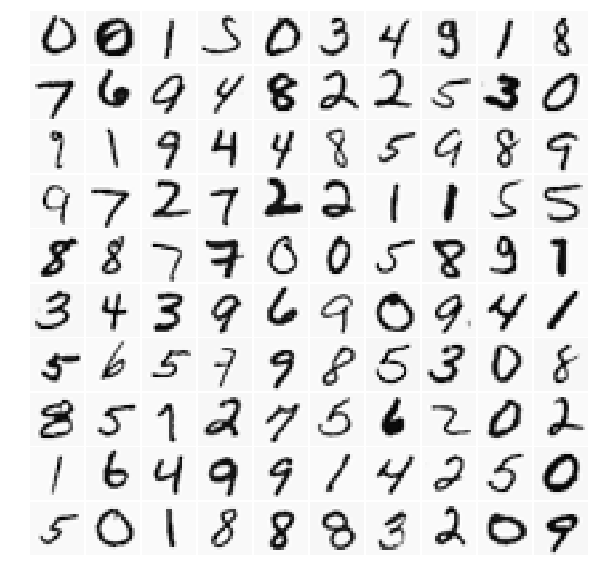

In [14]:
#Neural networks can form non-linear hypothesis and represent cmplex hypothesis

#reloading the data
data = loadmat(os.path.join("C:/Users/dynam/Desktop/Coursera AndrewNg/machine-learning-ex3/machine-learning-ex3/ex3","ex3data1.mat"))
X,y = data['X'],data['y'].ravel()
y[y==10] = 0
m = y.size
indices = np.random.permutation(m)
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]
displayData(sel)

In [15]:
#our input images have dim 20*20
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

#load the .math file containing the already ttrained weights using backpropagation algorithm
weights = loadmat(os.path.join("C:/Users/dynam/Desktop/Coursera AndrewNg/machine-learning-ex3/machine-learning-ex3/ex3","ex3weights.mat"))
Theta1,Theta2 = weights['Theta1'],weights['Theta2']

#since in matlab indexing starts from 1 and not 0,we swap the last and fist row
Theta2 = np.roll(Theta2,1,axis = 0)

In [16]:
print(Theta1.shape)
print(Theta2.shape)

(25, 401)
(10, 26)


In [20]:
def predict(Theta1,Theta2,X):
    #predict the label of an input given a trained NN
    
    #theta1 : weights for first layer : (2nd layer size X input size)
    #theta2 : weights for second layer : (output layer X 2nd hidden layer size)
    #X : image input : (#examples X image dim)
    #p : prediction vector :predictions for each example
    
    Theta1 = Theta1.T
    Theta2 = Theta2.T
    
    #promoting 1D array to 2D
    if X.ndim == 1:
        X = X[None]
    
    m = X.shape[0]
    num_labels = Theta2.shape[1]
    
    p = np.zeros(m)
    
    #add bias unit to X 
    print("X shape " + str(X.shape))
    print("m is {}".format(m))
    X = np.concatenate([np.ones((m,1)),X],axis = 1)
    
    a2 = sigmoid(np.dot(X,Theta1))
    #add bias unit to a2
    a2 = np.concatenate([np.ones((a2.shape[0],1)),a2],axis = 1)
    
    #output layer
    a3 = sigmoid(np.dot(a2,Theta2))
    p = np.argmax(a3,axis = 1)
    
    return p

In [21]:
pred = predict(Theta1,Theta2,X)
print("Training set Accuracy is : {:.2f}".format(np.mean(pred == y)*100))

X shape (5000, 400)
m is 5000
Training set Accuracy is : 96.94


X shape (1, 400)
m is 1
Neural Network Prediction: 8


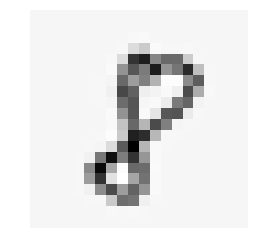

In [23]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')